## Time-Series Classification using SkTime Multivariate Analysis: Dhaka Tribune

Dataset: Dhaka Tribune 2021 Dataset

Resampling Technique: Daily

Author: Sumaia Parveen Shupti

Created on: 07/15/2021

Updated on: 07/18/2021

### Import Libraries

In [1]:
!pip install sktime

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score,accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score, confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")


plt.rcParams['figure.figsize'] = (10, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Load Dataset

In [3]:
df = pd.read_csv('../input/dhakatribunecomplete/Dhaka Tribune Complete Data.csv')
df['Accident date'] = pd.to_datetime(df['Accident date'])

df = df[['Accident date', 'Deaths']]
df = df.sort_values(by = 'Accident date')
df = df.reset_index(drop = True).set_index('Accident date').resample('1D').sum()
df = df.reset_index()
df['Deaths'] = df['Deaths'].fillna(0)
print(df.shape)
df.head(12)

(1829, 2)


,Accident date,Deaths
0,2016-06-24,3.0
1,2016-06-25,0.0
2,2016-06-26,0.0
3,2016-06-27,0.0
4,2016-06-28,0.0
5,2016-06-29,0.0
6,2016-06-30,0.0
7,2016-07-01,0.0
8,2016-07-02,0.0
9,2016-07-03,0.0


### Feature Enginnering

In [4]:
df['Accident date'] = pd.to_datetime(df['Accident date'])
df['Year'] = df['Accident date'].dt.year
df['Month'] = df['Accident date'].dt.month
df['Day'] = df['Accident date'].dt.day
df['DayofWeek'] = df['Accident date'].dt.weekday
df['Weekend_(y/n)'] = ((df['Accident date'].dt.dayofweek) // 5 == 1).astype(float)
df['DayofYear'] = df['Accident date'].dt.dayofyear
# Convert the date into a number (of days since some point)
fromDate = min(df['Accident date'])
df['DateInt'] = (df['Accident date'] - fromDate).astype(np.int64)/100000000000
df.head()

,Accident date,Deaths,Year,Month,Day,DayofWeek,Weekend_(y/n),DayofYear,DateInt
0,2016-06-24,3.0,2016,6,24,4,0.0,176,0.0
1,2016-06-25,0.0,2016,6,25,5,1.0,177,864.0
2,2016-06-26,0.0,2016,6,26,6,1.0,178,1728.0
3,2016-06-27,0.0,2016,6,27,0,0.0,179,2592.0
4,2016-06-28,0.0,2016,6,28,1,0.0,180,3456.0


### Binary Classification maybe?

In [5]:
# create a new column and use np.select to assign values to it using our lists as arguments
df['deathYorN'] = np.select([df['Deaths'] > 0], [1])

# display updated DataFrame
df.head(12)

,Accident date,Deaths,Year,Month,Day,DayofWeek,Weekend_(y/n),DayofYear,DateInt,deathYorN
0,2016-06-24,3.0,2016,6,24,4,0.0,176,0.0,1
1,2016-06-25,0.0,2016,6,25,5,1.0,177,864.0,0
2,2016-06-26,0.0,2016,6,26,6,1.0,178,1728.0,0
3,2016-06-27,0.0,2016,6,27,0,0.0,179,2592.0,0
4,2016-06-28,0.0,2016,6,28,1,0.0,180,3456.0,0
5,2016-06-29,0.0,2016,6,29,2,0.0,181,4320.0,0
6,2016-06-30,0.0,2016,6,30,3,0.0,182,5184.0,0
7,2016-07-01,0.0,2016,7,1,4,0.0,183,6048.0,0
8,2016-07-02,0.0,2016,7,2,5,1.0,184,6912.0,0
9,2016-07-03,0.0,2016,7,3,6,1.0,185,7776.0,0


In [6]:
df.dtypes

Accident date    datetime64[ns]
Deaths                  float64
Year                      int64
Month                     int64
Day                       int64
DayofWeek                 int64
Weekend_(y/n)           float64
DayofYear                 int64
DateInt                 float64
deathYorN                 int64
dtype: object

### Feature Corelation

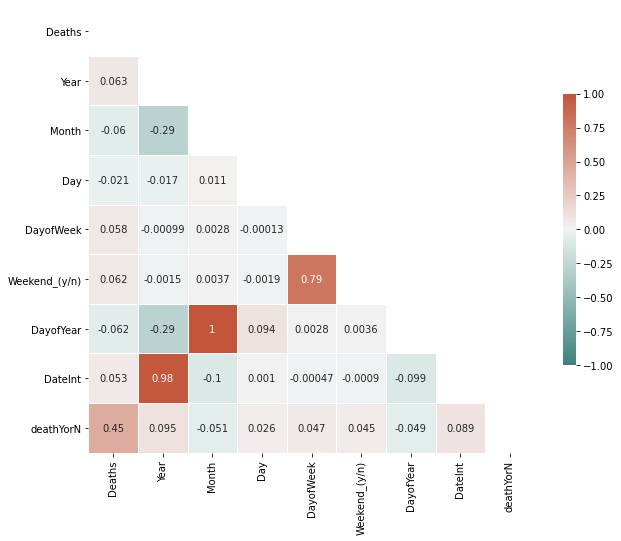

In [7]:
import seaborn as sns

correlation = df.corr()

mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(180, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin =-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

### Train Test Split

In [8]:
start_ = df['Accident date'].max()
end_ = df['Accident date'].min()

test_end = df['Accident date'].max()
test_start = df['Accident date'].max() - timedelta(days = 90)

train_end = test_start - timedelta(days = 1)
train_start = train_end - timedelta(days = 90*8)

print('Dataset Start Date: {}'.format(start_))
print('Dataset End Date: {}'.format(end_))
print (' ')
print('Train Set Start Date: {}'.format(train_start))
print('Train Set End Date: {}'.format(train_end))
print (' ')
print('Test Set Start Date: {}'.format(test_start))
print('Test Set End Date: {}'.format(test_end))
print (' ')

Dataset Start Date: 2021-06-26 00:00:00
Dataset End Date: 2016-06-24 00:00:00
 
Train Set Start Date: 2019-04-07 00:00:00
Train Set End Date: 2021-03-27 00:00:00
 
Test Set Start Date: 2021-03-28 00:00:00
Test Set End Date: 2021-06-26 00:00:00
 


In [9]:
mask = (df['Accident date'] > train_start) & (df['Accident date'] <= train_end)
train = df.loc[mask]
train = train.drop('Accident date', 1)
train = train.drop('Deaths', 1)

mask = (df['Accident date'] > test_start) & (df['Accident date'] <= test_end)
test = df.loc[mask]
test = test.drop('Accident date', 1)
test = test.drop('Deaths', 1)

In [10]:
train.tail()

,Year,Month,Day,DayofWeek,Weekend_(y/n),DayofYear,DateInt,deathYorN
1733,2021,3,23,1,0.0,82,1497312.0,0
1734,2021,3,24,2,0.0,83,1498176.0,0
1735,2021,3,25,3,0.0,84,1499040.0,0
1736,2021,3,26,4,0.0,85,1499904.0,1
1737,2021,3,27,5,1.0,86,1500768.0,0


In [11]:
test.head()

,Year,Month,Day,DayofWeek,Weekend_(y/n),DayofYear,DateInt,deathYorN
1739,2021,3,29,0,0.0,88,1502496.0,0
1740,2021,3,30,1,0.0,89,1503360.0,0
1741,2021,3,31,2,0.0,90,1504224.0,1
1742,2021,4,1,3,0.0,91,1505088.0,0
1743,2021,4,2,4,0.0,92,1505952.0,0


In [12]:
# Train-Test Split
X_train = train.drop('deathYorN', axis = 1) 
y_train = train[['deathYorN']]

X_test = test.drop('deathYorN', axis = 1) 
y_test = test[['deathYorN']]

<AxesSubplot:xlabel='deathYorN', ylabel='count'>

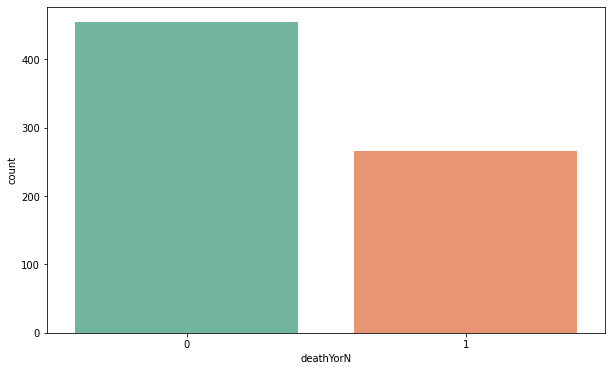

In [13]:
sns.countplot(y_train.deathYorN, palette = "Set2")

### Creating Synthetic Classes

In [14]:
# import SMOTE 
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 25, sampling_strategy='auto')   # again we are eqalizing both the classes

# fit the sampling
X_train, y_train = sm.fit_resample(X_train, y_train)
np.unique(y_train, return_counts=True)     # Y_train is numpy array, so unique() functions returns the count of all the unique elements in the array

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Count of Classes

<AxesSubplot:xlabel='deathYorN', ylabel='count'>

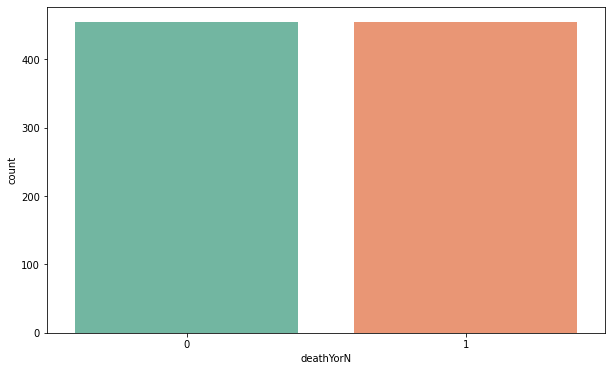

In [15]:
sns.countplot(y_train.deathYorN, palette = "Set2")

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.datasets import load_basic_motions
from sktime.transformations.panel.compose import ColumnConcatenator

In [17]:
# binary target variable
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)

[0 1] [454 454]


In [18]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [19]:
X_train_series.shape

(908, 7, 1)

In [20]:
X_test_series.shape

(90, 7, 1)

In [21]:
y_train = np. asarray(y_train)
y_test = np. asarray(y_test)

In [22]:
y_train.shape

(908, 1)

In [23]:
steps = [
    ("concatenate", ColumnConcatenator()),
    ("classify", TimeSeriesForestClassifier(n_estimators=100)),
]
clf = Pipeline(steps)
clf.fit(X_train_series, y_train)
clf.score(X_test_series, y_test)

0.6777777777777778

In [24]:
predictions = clf.predict(X_test_series)

In [25]:
predictions

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0])

In [26]:
test["Label"] = predictions
test

,Year,Month,Day,DayofWeek,Weekend_(y/n),DayofYear,DateInt,deathYorN,Label
1739,2021,3,29,0,0.0,88,1502496.0,0,1
1740,2021,3,30,1,0.0,89,1503360.0,0,0
1741,2021,3,31,2,0.0,90,1504224.0,1,0
1742,2021,4,1,3,0.0,91,1505088.0,0,1
1743,2021,4,2,4,0.0,92,1505952.0,0,0
...,...,...,...,...,...,...,...,...,...
1824,2021,6,22,1,0.0,173,1575936.0,0,0
1825,2021,6,23,2,0.0,174,1576800.0,1,1
1826,2021,6,24,3,0.0,175,1577664.0,0,0
1827,2021,6,25,4,0.0,176,1578528.0,0,0


### **Prediction on Unseen Data**

In [27]:
unseen_predictions = test.copy()
unseen_predictions["Date"] = df['Accident date'][1739:]
unseen_predictions = unseen_predictions.set_index('Date')
unseen_predictions

,Year,Month,Day,DayofWeek,Weekend_(y/n),DayofYear,DateInt,deathYorN,Label
Date,,,,,,,,,
2021-03-29,2021,3,29,0,0.0,88,1502496.0,0,1
2021-03-30,2021,3,30,1,0.0,89,1503360.0,0,0
2021-03-31,2021,3,31,2,0.0,90,1504224.0,1,0
2021-04-01,2021,4,1,3,0.0,91,1505088.0,0,1
2021-04-02,2021,4,2,4,0.0,92,1505952.0,0,0
...,...,...,...,...,...,...,...,...,...
2021-06-22,2021,6,22,1,0.0,173,1575936.0,0,0
2021-06-23,2021,6,23,2,0.0,174,1576800.0,1,1
2021-06-24,2021,6,24,3,0.0,175,1577664.0,0,0


### Viz of Actual vs Prediction

In [28]:
actuals = unseen_predictions.deathYorN
prediction = unseen_predictions.Label

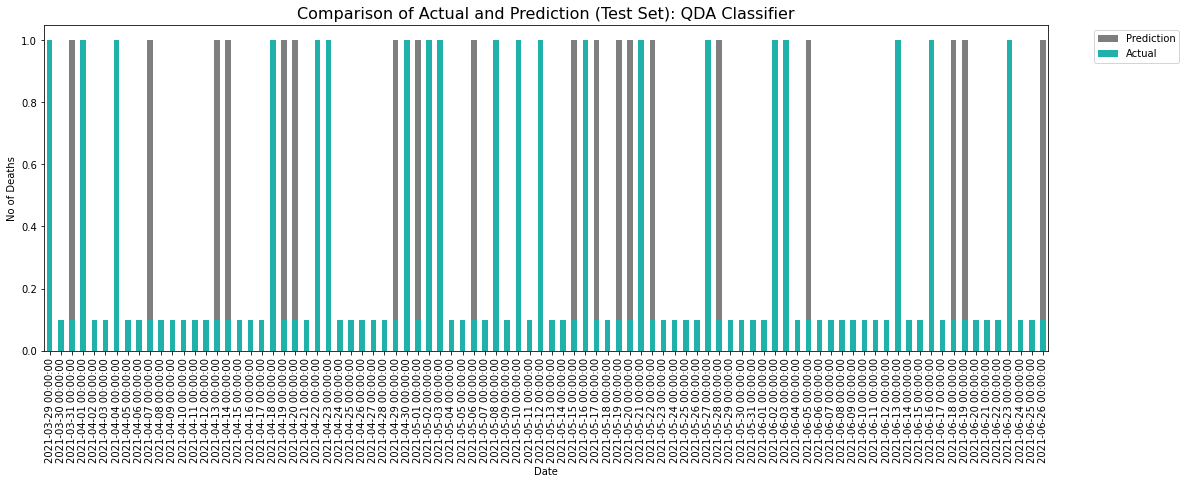

In [29]:
actual_plt = actuals.replace(0, 0.1)
pred_plt = prediction.replace(0, 0.1)

plt.rcParams["figure.figsize"] = [18, 6]

actual_plt.plot(kind = 'bar', linewidth = 1, label = 'Prediction', color = 'black', linestyle = '--', alpha = 0.5)
pred_plt.plot(kind = 'bar', linewidth = 1, label = 'Actual', color = 'lightseagreen')
plt.ylabel('No of Deaths')
plt.title('Comparison of Actual and Prediction (Test Set): QDA Classifier', fontsize = 16)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

### Unseen Data: Confusion Matrix

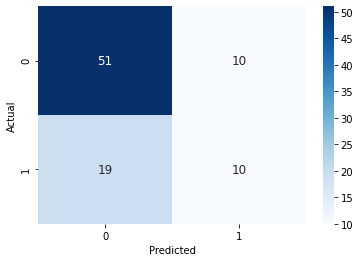

TP: 10, FP: 10, TN: 51, FN: 19


In [30]:
data = confusion_matrix(actuals, prediction)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6, 4))
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size
plt.show()
        
tn, fp, fn, tp = confusion_matrix(actuals, prediction).ravel()
print ("TP: {}, FP: {}, TN: {}, FN: {}".format(tp, fp, tn, fn))

### Unsssen Data: ROC & Precision-Recall Curve

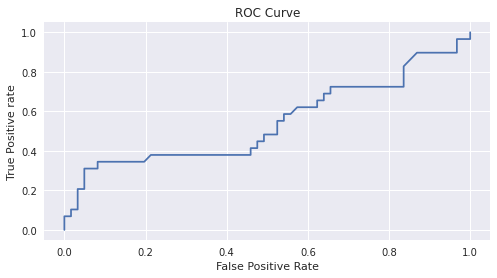

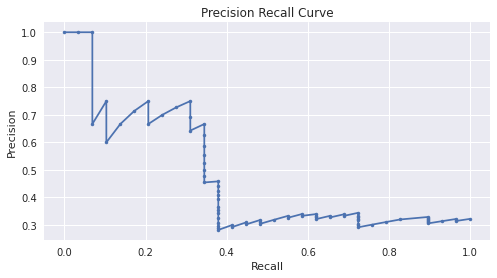

In [31]:
# predict probabilities
pred_prob = clf.predict_proba(X_test_series)

roc_auc = []
pr_auc = []

fpr, tpr, thresh = roc_curve(actuals, pred_prob[:, 1], pos_label=1)
roc_auc.append(roc_auc_score(actuals, prediction))
    
plt.style.use('seaborn')
plt.figure(figsize=(8, 4))
# plot roc curves
plt.plot(fpr, tpr)
    
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC', dpi=300)
plt.show();
    
# calculate model precision-recall curve
# precision, recall, _ = precision_recall_curve(y_hat , y_test)
precision, recall, _ = precision_recall_curve(actuals, pred_prob[:, 1], pos_label=1)
pr_auc.append(auc(recall, precision))
    
# plot the model precision-recall curve
plt.style.use('seaborn')
plt.figure(figsize=(8, 4))
plt.plot(recall, precision, marker='.')
plt.title('Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

### Recall, Precision & F1 Score

In [32]:
def macro_weighted_prec_rec(y_test, y_hat):
    
    acc_test = metrics.accuracy_score(y_test, y_hat)
    print ("Accuracy Score of Test Set:", acc_test)
    
    print('.')
    
    rec_ = metrics.recall_score(y_test, y_hat)
    print ("Recall Score:", rec_)
    
    rec_mac = metrics.recall_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of Recall Score:", rec_mac)

    rec_wei = metrics.recall_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of Recall Score:", rec_wei)
    
    print ('.')
    
    prec_mac = metrics.precision_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of Precision Score:", prec_mac)

    prec_wei = metrics.precision_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of Precision Score:", prec_wei)
    
    print ('.')

    f1_mac = metrics.f1_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of F1 Score:", f1_mac)

    f1_wei = metrics.f1_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of F1 Score:", f1_wei)

In [33]:
macro_weighted_prec_rec(actuals, prediction)

Accuracy Score of Test Set: 0.6777777777777778
.
Recall Score: 0.3448275862068966
Macro Average of Recall Score: 0.5904465799886942
Weighted Average of Recall Score: 0.6777777777777778
.
Macro Average of Precision Score: 0.6142857142857143
Weighted Average of Precision Score: 0.6549206349206349
.
Macro Average of F1 Score: 0.593394609752298
Weighted Average of F1 Score: 0.6592546433331603


### Distribution Plot of the Unseen Data

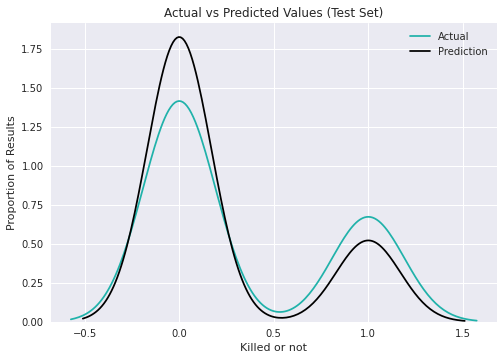

In [34]:
ax2 = sns.distplot(actuals, hist=False, color='lightseagreen', label = 'Actual')
sns.distplot(prediction, hist=False, ax=ax2, color='black', label = 'Prediction')
plt.title('Actual vs Predicted Values (Test Set)')
plt.xlabel('Killed or not')
plt.ylabel('Proportion of Results')
plt.legend()
plt.show()

### References

*  [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*  [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*  [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*  [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*  [Relationship between Precision-Recall and ROC Curves](https://www.biostat.wisc.edu/~page/rocpr.pdf)

* https://github.com/mljar/mljar-supervised/